In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

### ResNet18 Model Definition 

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out


In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super().__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], 2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1,1))(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=100):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

### CIFAR-100 Training

In [10]:
def train_cifar100():
    # Data preparation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    
    # Model setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet18(num_classes=100).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    # Training loop
    num_epochs =20
    train_losses, test_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        scheduler.step()
        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)
        
        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        accuracy = 100 * correct / total
        test_accs.append(accuracy)
        print(f'Epoch {epoch+1}: Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # Save model and plot results
    torch.save(model.state_dict(), 'cifar100_resnet18.pth')
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.subplot(1,2,2)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.savefig('cifar100_training.png')
    plt.show()
    
    return model

### CIFAR-10 Prediction & Visualization 

In [11]:
def predict_and_visualize_cifar10(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load and modify model
    model = ResNet18(num_classes=100).to(device)
    model.load_state_dict(torch.load(model_path))
    model.linear = nn.Linear(512, 10).to(device)  # Change to CIFAR-10 classes
    
    # CIFAR-10 data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_features = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get features before final layer
            features = model.conv1(inputs)
            features = model.bn1(features)
            features = nn.ReLU()(features)
            features = model.layer1(features)
            features = model.layer2(features)
            features = model.layer3(features)
            features = model.layer4(features)
            features = nn.AdaptiveAvgPool2d((1,1))(features)
            features = features.view(features.size(0), -1)
            
            outputs = model.linear(features)
            _, preds = torch.max(outputs, 1)
            
            all_features.append(features.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_features = np.concatenate(all_features)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.savefig('cifar10_confusion.png')
    plt.show()
    
    # t-SNE Visualization (using subset for speed)
    sample_idx = np.random.choice(len(all_features), 1000, replace=False)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(all_features[sample_idx])
    
    plt.figure(figsize=(10,8))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=all_labels[sample_idx], cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=range(10))
    plt.clim(-0.5, 9.5)
    plt.title('t-SNE Visualization of CIFAR-10 Features')
    plt.savefig('cifar10_tsne.png')
    plt.show()
    
    # Calculate accuracy
    accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
    print(f'CIFAR-10 Test Accuracy: {accuracy:.2f}%')


### Execution

Training ResNet18 on CIFAR-100...


Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████| 391/391 [26:25<00:00,  4.05s/it]


Epoch 1: Loss: 3.9455, Accuracy: 14.11%


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████| 391/391 [26:12<00:00,  4.02s/it]


Epoch 2: Loss: 3.3302, Accuracy: 22.92%


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████| 391/391 [26:12<00:00,  4.02s/it]


Epoch 3: Loss: 2.8495, Accuracy: 31.73%


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████| 391/391 [25:33<00:00,  3.92s/it]


Epoch 4: Loss: 2.3955, Accuracy: 40.99%


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████| 391/391 [25:49<00:00,  3.96s/it]


Epoch 5: Loss: 2.0819, Accuracy: 43.46%


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████| 391/391 [25:29<00:00,  3.91s/it]


Epoch 6: Loss: 1.8719, Accuracy: 47.98%


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████| 391/391 [26:04<00:00,  4.00s/it]


Epoch 7: Loss: 1.7312, Accuracy: 44.07%


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████| 391/391 [26:23<00:00,  4.05s/it]


Epoch 8: Loss: 1.6335, Accuracy: 48.39%


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████| 391/391 [25:50<00:00,  3.96s/it]


Epoch 9: Loss: 1.5565, Accuracy: 52.30%


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [26:19<00:00,  4.04s/it]


Epoch 10: Loss: 1.4856, Accuracy: 50.78%


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [26:09<00:00,  4.01s/it]


Epoch 11: Loss: 1.4333, Accuracy: 52.74%


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [27:14<00:00,  4.18s/it]


Epoch 12: Loss: 1.3895, Accuracy: 52.82%


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [26:03<00:00,  4.00s/it]


Epoch 13: Loss: 1.3445, Accuracy: 51.27%


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [25:51<00:00,  3.97s/it]


Epoch 14: Loss: 1.3211, Accuracy: 50.15%


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [26:02<00:00,  4.00s/it]


Epoch 15: Loss: 1.2930, Accuracy: 52.26%


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [25:49<00:00,  3.96s/it]


Epoch 16: Loss: 1.2613, Accuracy: 55.06%


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [25:57<00:00,  3.98s/it]


Epoch 17: Loss: 1.2360, Accuracy: 55.08%


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [25:34<00:00,  3.92s/it]


Epoch 18: Loss: 1.2206, Accuracy: 51.77%


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [24:18<00:00,  3.73s/it]


Epoch 19: Loss: 1.2046, Accuracy: 54.39%


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████| 391/391 [24:08<00:00,  3.71s/it]


Epoch 20: Loss: 1.1787, Accuracy: 52.17%


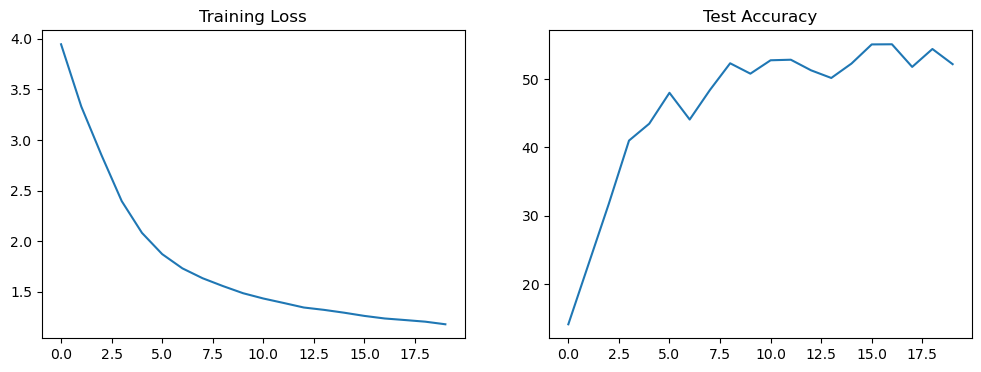


Predicting on CIFAR-10 with visualizations...


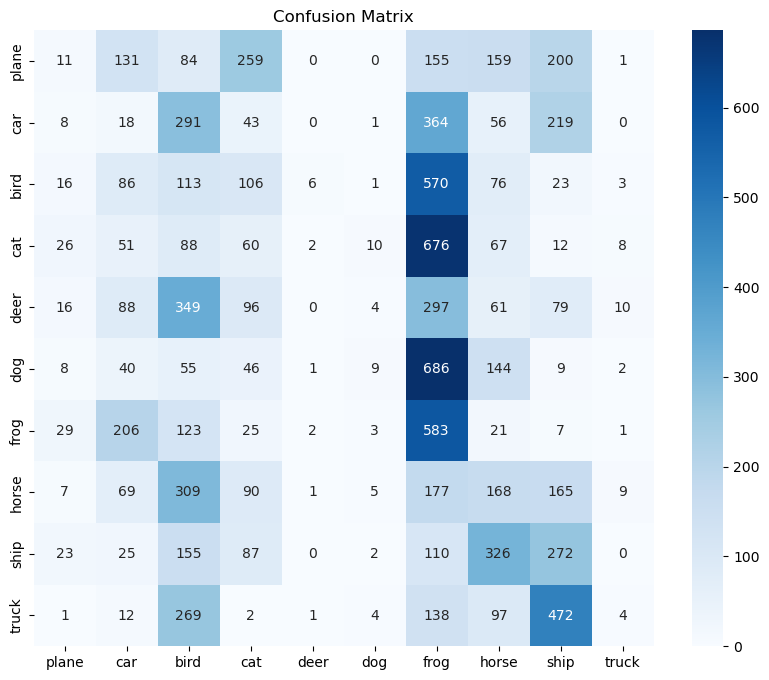

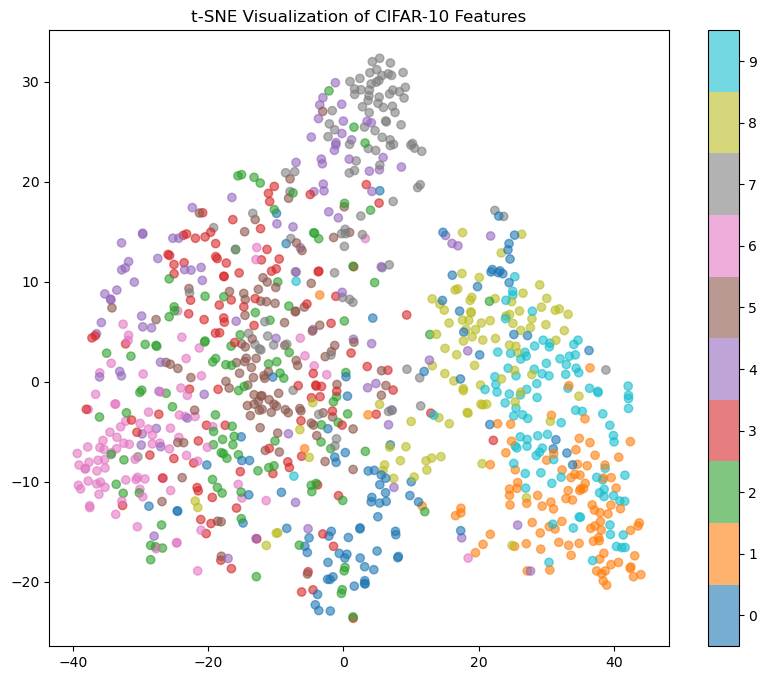

CIFAR-10 Test Accuracy: 12.38%


In [12]:
# ====================== Execute ======================
if __name__ == '__main__':
    # Train on CIFAR-100
    print("Training ResNet18 on CIFAR-100...")
    model = train_cifar100()
    
    # Predict and visualize on CIFAR-10
    print("\nPredicting on CIFAR-10 with visualizations...")
    predict_and_visualize_cifar10('cifar100_resnet18.pth')